In [12]:
import dash
from dash import dash_table
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objects as go
import plotly.express as px
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
import matplotlib.dates as mdates
import GraphHelpers as GH
from bisect import bisect_left, bisect_right
%matplotlib inline

In [22]:
# Data extracted from CropData.cs InitialiseCropData() method
CropCoefficients = pd.read_excel('C:\\GitHubRepos\\Overseer-testing\\CropCoefficients\\CropCoefficients.xlsx')
CropCoefficients.set_index(['CropName'],inplace=True)
Categories = CropCoefficients.Category.drop_duplicates().values
CatFilt = (CropCoefficients.loc[:,'Category'] != 'Undefined') & (CropCoefficients.loc[:,'Category'] != 'Pasture')
CropCoefficients = CropCoefficients.loc[CatFilt,:]

LincolnMet = pd.read_csv('C:\GitHubRepos\Weather\Broadfields\LincolnClean.met',delimiter = '\t')
LincolnMet.name = 'Lincoln'
GoreMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\GoreClean.met',delimiter = '\t')
GoreMet.name = 'Gore'
WhatatuMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\WhatatuClean.met',delimiter = '\t')
WhatatuMet.name = 'Napier'
PukekoheMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\PukekoheClean.met',delimiter = '\t')
PukekoheMet.name = 'Pukekohe'

metFiles ={'Pukekohe':PukekoheMet,'Whatatu':WhatatuMet,'Lincoln':LincolnMet,'Gore':GoreMet}

for f in metFiles.keys():
    metFiles[f].loc[:,'Date'] = pd.to_datetime(metFiles[f].loc[:,'Date'])
    metFiles[f].set_index('Date',inplace=True)


0.9926084586557181


Text(0.5, 0, 'Temperature accumulation')

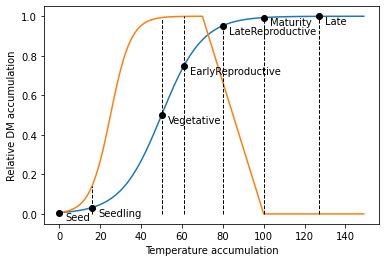

In [3]:
BiomassScaller = []
Covers = []
Xo_Biomass = 50
b_Biomass = Xo_Biomass*0.2
A_cov = 1
T_mat = Xo_Biomass*2
T_sen = T_mat-30
Xo_cov = T_mat * 0.25
b_cov = Xo_cov * 0.2
Tts = range(150)
for tt in Tts:
    BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
    cover = 0
    if tt < T_sen:
        cover = A_cov * 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
    else:
        if tt < T_mat:
            cover = A_cov * (1-(tt-T_sen)/(T_mat-T_sen))
    Covers.append(cover)
DMscaller = pd.DataFrame(index=Tts,data=BiomassScaller,columns=['scaller'])
DMscaller.loc[:,'cover'] = Covers
print(DMscaller.loc[99,'scaller'])
plt.plot(DMscaller.loc[:,'scaller'])
plt.plot(DMscaller.loc[:,'cover'])
DMscaller.loc[:,'max'] = DMscaller.max(axis=1)

Methods = ['Seed','Seedling','Vegetative','EarlyReproductive','LateReproductive','Maturity','Late']
PrpnMaxDM = [0.0066,0.03,0.5,0.75,0.95,0.9933,0.9995]
StagePropns = pd.DataFrame(index = Methods, data = PrpnMaxDM,columns=['PrpnMaxDM']) 
for p in StagePropns.index:
    TTatProp = bisect_left(DMscaller.scaller,StagePropns.loc[p,'PrpnMaxDM'])
    StagePropns.loc[p,'PrpnTt'] = TTatProp/T_mat
    plt.plot(StagePropns.loc[p,'PrpnTt']*T_mat,StagePropns.loc[p,'PrpnMaxDM'],'o',color='k')
    plt.text(StagePropns.loc[p,'PrpnTt']*T_mat+3,StagePropns.loc[p,'PrpnMaxDM'],p,verticalalignment='top')
    plt.plot([StagePropns.loc[p,'PrpnTt']*T_mat]*2,[0,DMscaller.loc[round(StagePropns.loc[p,'PrpnTt'] * T_mat),'max']],'--',color='k',lw=1)
plt.ylabel('Relative DM accumulation')
plt.xlabel('Temperature accumulation')

In [4]:
Xo_Biomass

50

In [5]:
def CalcCovers(Tts, A_cov, Xo_cov, b_cov,T_sen,T_mat):
    Covers = []
    for tt in Tts:
        cover = 0
        if tt < T_sen:
            cover = A_cov * 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
        else:
            if tt < T_mat:
                cover = A_cov * (1-(tt-T_sen)/(T_mat-T_sen))
        Covers.append(cover)
    return Covers

def CalcBiomass(Tts,Xo_Biomass,b_Biomass):
    BiomassScaller = []
    for tt in Tts:
        BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
    return BiomassScaller    

def NDilution(An,Bn,c,R):
    return An * (1 + Bn * np.exp(c*R))

def MakeDate(DateString,CheckDate):
    Date = datetime.datetime(2000,int(datetime.datetime.strptime(DateString.split('-')[1],'%b').month),int(DateString.split('-')[0]))
    if CheckDate == '':
        CheckDate = datetime.datetime(2000,1,1)
    if Date < CheckDate:
        Date = datetime.datetime(2001,int(datetime.datetime.strptime(DateString.split('-')[1],'%b').month),int(DateString.split('-')[0]))
    return Date

def tt(x,b):
    return max(0,x-b)

def firstIndex(series,threshold):
    pos=0
    passed = False
    while passed == False:
        if series.iloc[pos] < threshold:
            passed = True
        pos +=1
    return pos

def DeriveParamsAndGraph(ax,Met,Establish,Harvest,EstablishStage,HarvestStage,totalN):
    ## Calculate median thermaltime for location
    FirstYear = int(Met.Year[0])
    years = [int(x) for x in Met.Year.drop_duplicates().values[1:-1]]
    day = int(Establish.split('-')[0])
    month = datetime.datetime.strptime(Establish.split('-')[1],'%b').month
    FirstDate = datetime.datetime(FirstYear,month,day)

    Met.loc[:,'tt'] = [tt(x,5) for x in Met.Temp]
    TT = pd.DataFrame(columns = years,index = range(1,368))
    for y in years:
        start = Establish + '-' + str(y)
        end = Harvest + '-' + str(y+1)
        duration = (datetime.datetime.strptime(end,'%d-%b-%Y') - datetime.datetime.strptime(start,'%d-%b-%Y')).days
        try:
            TT.loc[:,y] = Met.loc[start:,'tt'].cumsum().values[:367]
        except:
            do = 'nothing'
    TTmed = (TT.median(axis=1))/30 # (TT.median(axis=1)-[5*x for x in TT.index])/30
    TTmed.index = pd.date_range(start=Establish+'-2000',periods=367,freq='D',name='Date')
    TTmed.name = 'Tt'

    ## Calculate date variables
    EstabDate = MakeDate(Establish,'')
    HarvestDate = MakeDate(Harvest,EstabDate)
    print(HarvestDate)

    ## Calculate model parameters 
    Tt_Harv = TTmed[HarvestDate]
    Tt_estab = Tt_Harv * (StagePropns.loc[EstablishStage,'PrpnTt']/StagePropns.loc[HarvestStage,'PrpnTt'])
    Xo_Biomass = (Tt_Harv + Tt_estab) *.5 * (1/StagePropns.loc[HarvestStage,'PrpnTt'])
    b_Biomass = Xo_Biomass * .2
    # Calculate fitted patterns
    CropPatterns = pd.DataFrame(TTmed+Tt_estab)
    CropPatterns.loc[:,'biomass'] = CalcBiomass(CropPatterns.Tt.values,Xo_Biomass,b_Biomass) * 1/(StagePropns.loc[HarvestStage,'PrpnMaxDM']) * totalN
    
    CropPatterns = CropPatterns.iloc[:duration,:]
    plt.plot(CropPatterns.index,CropPatterns.biomass,color='green')
    #plt.plot(CropPatterns.index,CropPatterns.nitrogen)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xlim(EstabDate,HarvestDate)
    return CropPatterns
    #plt.ylim(0,1.1)

def MineralisationGraph(ax,Met,Establish,Harvest,EstablishStage,HarvestStage,p,col):
    ## Calculate median thermaltime for location
    FirstYear = int(Met.Year[0])
    years = [int(x) for x in Met.Year.drop_duplicates().values[1:-1]]
    day = int(Establish.split('-')[0])
    month = datetime.datetime.strptime(Establish.split('-')[1],'%b').month
    FirstDate = datetime.datetime(FirstYear,month,day)

    Met.loc[:,'tt'] = [tt(x,5) for x in Met.Temp]
    TT = pd.DataFrame(columns = years,index = range(1,368))
    for y in years:
        start = Establish + '-' + str(y)
        end = Establish + '-' + str(y+1)
        try:
            TT.loc[:,y] = Met.loc[start:,'tt'].cumsum().values[:367]
        except:
            do = 'nothing'
    TTmed = (TT.median(axis=1))/30 # (TT.median(axis=1)-[5*x for x in TT.index])/30
    TTmed.index = pd.date_range(start=Establish+'-2000',periods=367,freq='D',name='Date')
    TTmed.name = 'Tt'

    ## Calculate date variables
    EstabDate = MakeDate(Establish,'')
    HarvestDate = MakeDate(Harvest,EstabDate)
    Tt_Harv = TTmed[HarvestDate]
    Tt_estab = Tt_Harv * (StagePropns.loc[EstablishStage,'PrpnTt']/StagePropns.loc[HarvestStage,'PrpnTt'])
    CropPatterns = pd.DataFrame(TTmed+Tt_estab)
    CropPatterns.loc[:,'biomass'] = CropPatterns.Tt.values * p
    plt.plot(CropPatterns.index,CropPatterns.biomass,color=col)
    #plt.plot(CropPatterns.index,CropPatterns.nitrogen)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xlim(EstabDate,HarvestDate)
    return CropPatterns.loc[:HarvestDate,'biomass'].max()
    #plt.ylim(0,1.1)

    
def Deficit(ax,Met,Establish,Harvest,EstablishStage,HarvestStage,r,m,InitialN,FinalN,TotalCropN,splits,Eff):
    ## Calculate median thermaltime for location
    FirstYear = int(Met.Year[0])
    years = [int(x) for x in Met.Year.drop_duplicates().values[1:-1]]
    day = int(Establish.split('-')[0])
    month = datetime.datetime.strptime(Establish.split('-')[1],'%b').month
    FirstDate = datetime.datetime(FirstYear,month,day)

    Met.loc[:,'tt'] = [tt(x,5) for x in Met.Temp]
    TT = pd.DataFrame(columns = years,index = range(1,368))
    for y in years:
        start = Establish + '-' + str(y)
        end = Harvest + '-' + str(y+1)
        duration = (datetime.datetime.strptime(end,'%d-%b-%Y') - datetime.datetime.strptime(start,'%d-%b-%Y')).days
        try:
            TT.loc[:,y] = Met.loc[start:,'tt'].cumsum().values[:367]
        except:
            do = 'nothing'
    TTmed = (TT.median(axis=1))/30 # (TT.median(axis=1)-[5*x for x in TT.index])/30
    TTmed.index = pd.date_range(start=Establish+'-2000',periods=367,freq='D',name='Date')
    TTmed.name = 'Tt'
    ## Calculate date variables
    EstabDate = MakeDate(Establish,'')
    HarvestDate = MakeDate(Harvest,EstabDate)

    ## Calculate model parameters 
    Tt_Harv = TTmed[HarvestDate]
    Tt_estab = Tt_Harv * (StagePropns.loc[EstablishStage,'PrpnTt']/StagePropns.loc[HarvestStage,'PrpnTt'])
    Xo_Biomass = (Tt_Harv + Tt_estab) *.5 * (1/StagePropns.loc[HarvestStage,'PrpnTt'])
    b_Biomass = Xo_Biomass * .2

    # Calculate fitted patterns
    CropPatterns = pd.DataFrame(TTmed+Tt_estab)
    CropPatterns.loc[:,'biomass'] = CalcBiomass(CropPatterns.Tt.values,Xo_Biomass,b_Biomass) * 1/(StagePropns.loc[HarvestStage,'PrpnMaxDM']) * TotalCropN
    CropPatterns.loc[:,'residue'] = CropPatterns.Tt.values * r
    CropPatterns.loc[:,'mineralisation'] = CropPatterns.Tt.values * m
    CropPatterns.loc[:,'mineral'] = InitialN
    CropPatterns = CropPatterns.iloc[:duration,:]
    NFertReq = (CropPatterns.loc[:,'biomass'].max() + FinalN) - InitialN - CropPatterns.loc[:,'mineralisation'].max() - CropPatterns.loc[:,'residue'].max()
    NFertReq = NFertReq * 1/Eff
    NFertReq = np.ceil(NFertReq)
    NAppn = NFertReq/splits
    plength = duration/(splits + 1)
    xlocs = [0]
    plength = np.ceil(duration/(splits + 1))
    xlocs = []
    for x in range(1,int(splits+1)):
        xlocs.append(x * plength)
    FertApplied = 0
    FertAppNo = 0
    maxSoilN = max(InitialN,FinalN + NAppn)
    for d in range(1,CropPatterns.index.size):
        PotentialN = CropPatterns.iloc[d-1,4]+CropPatterns.iloc[:,2].diff()[d]+CropPatterns.iloc[:,3].diff()[d]-CropPatterns.iloc[:,1].diff()[d] 
        CropPatterns.iloc[d,4] = PotentialN
        if (CropPatterns.iloc[d-1,4] > CropPatterns.iloc[d,4]) and (PotentialN < FinalN) and (FertApplied < NFertReq): #and ((CropPatterns.iloc[d-1,4]-CropPatterns.iloc[d,4])<0):
            CropPatterns.iloc[d,4]  += NAppn * Eff
            FertApplied += NAppn
            plt.plot([CropPatterns.index[d]]*2,[CropPatterns.iloc[d-1,4],CropPatterns.iloc[d,4]],'-',color='k',lw=3)
            recString = CropPatterns.index[d].strftime('%d-%b') +'\n' +str(int(NAppn)) + ' kg/ha'
            plt.text(CropPatterns.index[int(xlocs[FertAppNo])],maxSoilN*1.1,recString,fontsize=8,rotation=0,horizontalalignment='center',verticalalignment='bottom')
            plt.arrow(CropPatterns.index[int(xlocs[FertAppNo])],maxSoilN*1.1,
                      (CropPatterns.index[d]-CropPatterns.index[int(xlocs[FertAppNo])]).days,
                      CropPatterns.iloc[d,4]-maxSoilN*1.1,
                      length_includes_head = True,)
            if FertAppNo == 0:
                FirstFertDay = d
            FertAppNo += 1
    plt.text(0.02,0.05,'Total N Fert = ' + str(int(np.ceil(NFertReq))) + ' kg/ha',transform=ax.transAxes,horizontalalignment='left',fontsize=8)
    plt.plot(CropPatterns.index,CropPatterns.mineral,color='blue')
    plt.text(CropPatterns.index[1],CropPatterns.iloc[0,4]*1.1,'Initial N \n' + str(int(InitialN))+ 'kg/ha',
             fontsize=8,horizontalalignment='left',verticalalignment='bottom',color='blue')
    plt.plot([CropPatterns.index[1],CropPatterns.index[30]], [CropPatterns.iloc[0,4]]*2,'--',color='blue')
    plt.text(CropPatterns.index[-1],CropPatterns.iloc[-1,4]*1.1,'Trigger N \n' + str(int(FinalN))+ 'kg/ha',
             fontsize=8,horizontalalignment='right',verticalalignment='bottom',color='purple')
    plt.plot([CropPatterns.index[FirstFertDay],CropPatterns.index[-1]], [CropPatterns.iloc[-1,4]]*2,'--',color='purple')
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xlim(EstabDate,HarvestDate)
    plt.ylim(0,maxSoilN*1.5)
    return CropPatterns

2001-03-01 00:00:00


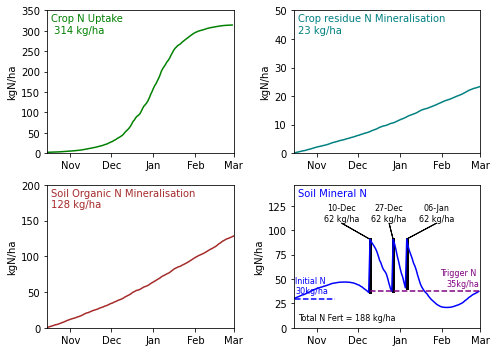

In [6]:
HarvestedYield = 70 # t/ha fresh weight
RejectProportion = 0.1 # Proportion of tubers left in feild
TotalProduct = HarvestedYield * (1 + RejectProportion)
DryYield = TotalProduct * 1000 * 0.22 # dry matter content of tubers
StoverYield = DryYield * 1/0.9 - DryYield # Harvest index
RootYield = (StoverYield+DryYield) * 0.1
ProductN = DryYield * 0.015
StoverN = StoverYield * 0.022
RootN = RootYield * 0.01
totalN = ProductN + StoverN + RootN
ResCoeff = 0.5
SOMCoeff = 2.75
InitN = 30
FinalN = 35
Splits = 3
GasLosses = 0.1
LeachingLosses = 0.0
Eff = 1- (GasLosses + LeachingLosses)
Fig = plt.figure(figsize=(7,5))
ax = Fig.add_subplot(2,2,1)
DeriveParamsAndGraph(ax,LincolnMet,'15-Oct','1-Mar','Seed','Maturity',totalN)
plt.ylabel('kgN/ha')
plt.ylim(0,350)
plt.text(0.02,0.98,'Crop N Uptake \n ' + str(int(totalN)) +' kg/ha',transform=ax.transAxes,verticalalignment='top',color='green')
ax = Fig.add_subplot(2,2,2)
MinN = MineralisationGraph(ax,LincolnMet,'15-Oct','1-Mar','Seed','Maturity',ResCoeff,'teal')
plt.ylabel('kgN/ha')
plt.ylim(0,50)
plt.text(0.02,0.98,'Crop residue N Mineralisation \n' + str(int(MinN)) +' kg/ha',
         transform=ax.transAxes,verticalalignment='top',color='teal')
ax = Fig.add_subplot(2,2,3)
SOMN = MineralisationGraph(ax,LincolnMet,'15-Oct','1-Mar','Seed','Maturity',SOMCoeff,'brown')
plt.ylabel('kgN/ha')
plt.ylim(0,200)
plt.text(0.02,0.98,'Soil Organic N Mineralisation\n' + str(int(SOMN)) +' kg/ha',transform=ax.transAxes,verticalalignment='top',color='brown')
ax = Fig.add_subplot(2,2,4)
CropPats = Deficit(ax,LincolnMet,'15-Oct','1-Mar','Seed','Maturity',ResCoeff,SOMCoeff,InitN,FinalN,totalN,Splits,Eff)
plt.ylabel('kgN/ha')
plt.text(0.02,0.92,'Soil Mineral N',transform=ax.transAxes,color='blue')
plt.tight_layout()